# Install Libraries

In [1]:
!pip install pillow

# Download Dataset

In [2]:
DATASET_DIR = "scalene_triangle_0_355_step5"
!rm -rf "$DATASET_DIR"
!curl -L https://github.com/joshbarrass/Y4ProjectNotebooks/raw/master/scalene_triangle_0_355_step5.zip > "scalene_triangle_0_355_step5.zip"
!unzip -d "$DATASET_DIR" "scalene_triangle_0_355_step5.zip" > /dev/null

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   170  100   170    0     0    669      0 --:--:-- --:--:-- --:--:--   669
100  281k  100  281k    0     0   907k      0 --:--:-- --:--:-- --:--:--  907k


# Define Helper Functions

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from scipy.spatial.transform import Rotation as R

D6_SHAPE = (3, 2)

def normalise(x):
    return x / np.linalg.norm(x)

def from_SO3_to_6D(SO3):
    """Convert an SO(3) rotation matrix to a 6D internal representation."""
    return SO3[:,:2]

def from_6D_to_SO3(D6):
    """Convert a 6D internal representation to an SO(3) rotation matrix."""
    b1 = normalise(D6[:,0])
    b2 = normalise(D6[:,1] - np.dot(b1, D6[:,1])*b1)
    b3 = np.cross(b1, b2)
    return np.array([b1, b2, b3]).T

def tf_6D_to_SO3(D6):
  """tensorflow-compatible conversion from 6D to SO(3). Used in the D6Convert layer."""
  a1 = D6[:,:,0]
  a2 = D6[:,:,1]
  b1 = tf.math.l2_normalize(a1, axis=-1)
  b2 = tf.math.l2_normalize(a2 - tf.reduce_sum(b1*a2)*b1, axis=-1)
  b3 = tf.linalg.cross(b1, b2)
  return tf.stack([b1, b2, b3], axis=2)

class D6Convert(layers.Layer):
  def call(self, inputs):
    target_input_shape = tf.TensorShape(((None,) + D6_SHAPE))
    if not inputs.shape.is_compatible_with(target_input_shape):
      raise TypeError("inputs to D6Convert should have shape {}, not {}".format(target_input_shape, inputs.shape))
    return tf_6D_to_SO3(inputs)

### DEPRECATED: Returns wrong value
# def SO3_distance(M1, M2):
#  """Returns the distance between two SO3 matrices in degrees"""
#  R = M1 * np.linalg.inv(M2)
#  return np.rad2deg(np.arccos((np.trace(R)-1)/2))

# Implement Quaternion Maths

In [4]:
# quaternion [x, y, z, w]: w + xi + yj + zk === [b, c, d, a]: a + bi + cj + dk
# this is the format outputted by scipy
def quatmul(q1, q2):
  """Takes two scalar-last quaternions and performs the Hamilton product.
  
  https://en.wikipedia.org/wiki/Quaternion#Hamilton_product"""
  b1, c1, d1, a1 = q1
  b2, c2, d2, a2 = q2
  return np.array([
                   a1*b2 + b1*a2 + c1*d2 - d1*c1,
                   a1*c2 - b1*d2 + c1*a2 + d1*b2,
                   a1*d2 + b1*c2 - c1*b2 + d1*a2,
                   a1*a2 - b1*b2 - c1*c2 - d1*d2,
  ])

def quatconj(q):
  """Returns the conjugate of a scalar-last quaternion."""
  q_conj = -q
  q_conj[3] = -q_conj[3]
  return q_conj

def SO3_distance(M1, M2):
  """Returns the angle between two SO3 matrices in degrees.

  This is done by converting the matrices to quaternions and multiplying the
  conjugate of one with the other. The scalar part of the resulting quaternion
  is then cos(theta/2)"""
  Q1 = R.from_matrix(M1).as_quat()
  Q2 = R.from_matrix(M2).as_quat()
  q = quatmul(quatconj(Q1), Q2)
  return np.rad2deg(np.arccos(q[3])*2)

### TEST SO3_distance
test_tolerance = 0.001
for i in range(100):
  test_angle1, test_angle2 = np.random.uniform(0, 180, 2) # max difference should be 180, as > 180 is no longer the shortest angle
  testM1 = R.from_euler("zyx", [test_angle1, 0, 0], degrees=True).as_matrix()
  testM2 = R.from_euler("zyx", [test_angle2, 0, 0], degrees=True).as_matrix()
  test_true_angle = abs(test_angle1-test_angle2)
  test_angle = abs(SO3_distance(testM1, testM2))
  assert test_angle + test_tolerance > test_true_angle and test_angle - test_tolerance < test_true_angle

In [5]:
SO31 = R.from_euler("zyx",[3, 2, 1]).as_matrix()
D61 = from_SO3_to_6D(SO31)
SO32 = R.from_euler("zyx",[0.5, 1, 1.2]).as_matrix()
D62 = from_SO3_to_6D(SO32)
print("True:", SO31, "\n", SO32, sep="")
print("np1:", from_6D_to_SO3(D61))
print("np2:", from_6D_to_SO3(D62))
print("tf:", tf_6D_to_SO3(np.array([D61, D62])))

True:[[ 0.41198225  0.05872664  0.90929743]
 [-0.68124272 -0.64287284  0.35017549]
 [ 0.60512725 -0.76371834 -0.2248451 ]]
[[ 0.47415988 -0.25903472  0.84147098]
 [ 0.86199739 -0.05800686 -0.50358287]
 [ 0.17925654  0.96412459  0.19578273]]
np1: [[ 0.41198225  0.05872664  0.90929743]
 [-0.68124272 -0.64287284  0.35017549]
 [ 0.60512725 -0.76371834 -0.2248451 ]]
np2: [[ 0.47415988 -0.25903472  0.84147098]
 [ 0.86199739 -0.05800686 -0.50358287]
 [ 0.17925654  0.96412459  0.19578273]]
tf: tf.Tensor(
[[[ 0.41198225  0.05872664  0.90929743]
  [-0.68124272 -0.64287284  0.35017549]
  [ 0.60512725 -0.76371834 -0.2248451 ]]

 [[ 0.47415988 -0.25903472  0.84147098]
  [ 0.86199739 -0.05800686 -0.50358287]
  [ 0.17925654  0.96412459  0.19578273]]], shape=(2, 3, 3), dtype=float64)


# Load and Pre-Process Training Data

Dataset contains 72 images
Image shape is (50, 50, 1)
x will have shape (72, 50, 50, 1)
y will have shape (72, 3, 3)
Processing image files...


  0%|          | 0/72 [00:00<?, ?it/s]

Selecting test data...


  0%|          | 0/14 [00:00<?, ?it/s]

x_data has shape (58, 50, 50, 1)
y_data has shape (58, 3, 3)
x_test has shape (14, 50, 50, 1)
y_test has shape (14, 3, 3)
x_data values range from 0.0 to 0.8509804010391235
[[ 0.9848077   0.17364818  0.        ]
 [-0.17364818  0.9848077   0.        ]
 [ 0.          0.          1.        ]]


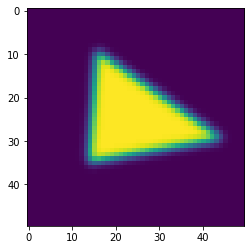

In [6]:
import os
import random
import numpy as np
from scipy.spatial.transform import Rotation as R
from PIL import Image, ImageFilter
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

random.seed(0)

RESIZE_SHAPE = (50, 50)

GAUSS_RADIUS = 1
image_filter = ImageFilter.GaussianBlur(radius=GAUSS_RADIUS)

image_files = os.listdir(DATASET_DIR)
total_images = len(image_files)
print(f"Dataset contains {total_images} images")
if total_images == 0:
  raise ValueError("dataset has no images")

# image_shape = Image.open(os.path.join(DATASET_DIR, image_files[0])).size
image_shape = RESIZE_SHAPE + (1,)
print(f"Image shape is {image_shape}")
x_data = np.zeros((total_images,) + image_shape, dtype="float32")
y_data = np.zeros((total_images, 3, 3), dtype="float32")
print(f"x will have shape {x_data.shape}")
print(f"y will have shape {y_data.shape}")
print("Processing image files...")
for i, imf in tqdm(enumerate(image_files), total=total_images):
  im = Image.open(os.path.join(DATASET_DIR, imf)).convert("L")
  im = im.resize(RESIZE_SHAPE)
  im = im.filter(image_filter)
  x_data[i,:,:] = np.array(im).reshape(image_shape)/255
  angle = float(os.path.splitext(imf)[0])
  y_data[i,:,:] = R.from_euler("zyx", (angle, 0, 0), True).as_matrix()

# take 20% of the images as test data
total_test_images = int(0.2*total_images)
x_test = np.zeros((total_test_images,) + x_data.shape[1:])
y_test = np.zeros((total_test_images,) + y_data.shape[1:])
print("Selecting test data...")
for i in tqdm(range(total_test_images)):
  r = random.randrange(x_data.shape[0])
  x_test[i] = x_data[r]
  x_data = np.delete(x_data, r, 0)
  y_test[i] = y_data[r]
  y_data = np.delete(y_data, r, 0)
print(f"x_data has shape {x_data.shape}")
print(f"y_data has shape {y_data.shape}")
print(f"x_test has shape {x_test.shape}")
print(f"y_test has shape {y_test.shape}")

print(f"x_data values range from {np.min(x_data)} to {np.max(x_data)}")

plt.imshow(x_data[0,:,:].reshape(RESIZE_SHAPE))
print(y_data[0,:,:])

# Construct Network

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

batch_size = 5
epochs = 200

model = keras.Sequential([
                          layers.InputLayer(input_shape=image_shape),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.MaxPool2D(pool_size=2, strides=2),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.MaxPool2D(pool_size=2, strides=2),
                          layers.Flatten(),
                          layers.Dense(64, activation="relu"),
                          layers.Dense(128, activation="relu"),
                          layers.Dense(256, activation="relu"),
                          layers.Dense(128, activation="relu"),
                          layers.Dense(64, activation="relu"),
                          layers.Dense(np.prod(D6_SHAPE), activation="tanh"),
                          layers.Reshape(D6_SHAPE),
                          D6Convert(),
])
model.summary()
model.compile(optimizer="sgd", loss="mean_squared_error", metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3872)              0         
                                                                 
 dense (Dense)               (None, 64)                2

# Train Model

Epoch 1/200
12/12 [==============================] - 1s 16ms/step - loss: 0.5196 - accuracy: 0.2816
Epoch 2/200
12/12 [==============================] - 0s 16ms/step - loss: 0.4444 - accuracy: 0.4885
Epoch 3/200
12/12 [==============================] - 0s 16ms/step - loss: 0.4465 - accuracy: 0.5805
Epoch 4/200
12/12 [==============================] - 0s 15ms/step - loss: 0.4281 - accuracy: 0.5747
Epoch 5/200
12/12 [==============================] - 0s 18ms/step - loss: 0.4310 - accuracy: 0.5805
Epoch 6/200
12/12 [==============================] - 0s 17ms/step - loss: 0.4486 - accuracy: 0.5805
Epoch 7/200
12/12 [==============================] - 0s 15ms/step - loss: 0.4126 - accuracy: 0.5747
Epoch 8/200
12/12 [==============================] - 0s 16ms/step - loss: 0.4296 - accuracy: 0.5690
Epoch 9/200
12/12 [==============================] - 0s 15ms/step - loss: 0.4139 - accuracy: 0.5805
Epoch 10/200
12/12 [==============================] - 0s 15ms/step - loss: 0.4059 - accuracy: 0.5805

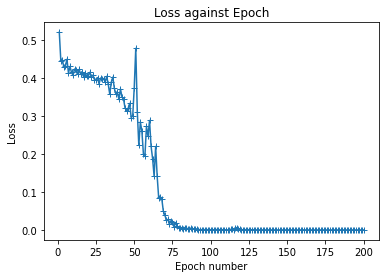

In [8]:
history = model.fit(
    x_data,
    y_data,
    batch_size,
    epochs,
)
plt.plot([i for i in range(1, len(history.history["loss"])+1)], history.history["loss"], "+-")
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.title("Loss against Epoch")
plt.show()

# Test Model

In [9]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.000633908377494663
Test accuracy: 0.9523809552192688


In [10]:
i = 6
print("True SO(3):\n", y_test[i].astype("float32"), end="\n\n", sep="")
prediction = model.predict(x_test[i].reshape((1,)+x_test[i].shape))[0]
print("SO(3) Prediction:\n", prediction, sep="")
print("Distance: {:.2f} degrees".format(SO3_distance(y_test[i], prediction)))

True SO(3):
[[ 0.70710677  0.70710677  0.        ]
 [-0.70710677  0.70710677  0.        ]
 [ 0.          0.          1.        ]]

SO(3) Prediction:
[[ 0.7267828   0.68622667 -0.02966204]
 [-0.68600243  0.7273569   0.01877757]
 [ 0.03446056  0.00670102  0.9993836 ]]
Distance: 2.61 degrees


# Analyse Results

  0%|          | 0/14 [00:00<?, ?it/s]

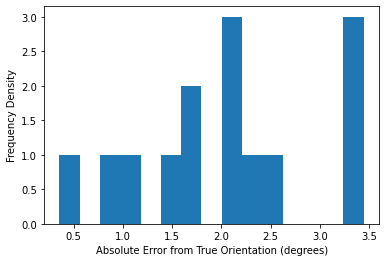

In [11]:
distances = np.zeros(x_test.shape[0])
for i in tqdm(range(x_test.shape[0])):
  prediction = model.predict(x_test[i].reshape((1,)+x_test[i].shape))[0]
  distances[i] = SO3_distance(y_test[i], prediction)

plt.hist(distances, bins=15)
plt.xlabel("Absolute Error from True Orientation (degrees)")
plt.ylabel("Frequency Density")
plt.show()

In [12]:
distance_mean = np.mean(distances)
distance_std = np.std(distances, ddof=1)
print(f"Average distance from the true value is {distance_mean:.2f} +- {distance_std:.2f}")

Average distance from the true value is 2.02 +- 0.96
